In [3]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm
import seaborn as sns
from trimesh import load_mesh

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
from utils.combine_tools import apply_qc
from utils.ccf_utils import pir_to_lps
from utils.plot_utils import combine_pdf_big

# Matplotlib inline for Jupyter
%matplotlib inline


# Pack data

In [4]:
criteria_name = 'basic_ephys_low'

In [5]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying bounds for isi_violations: [0.0, 0.5]
 - isi_violations: 17847 -> 11408 units passed
Applying items for qc_pass: [True]
 - qc_pass: 11408 -> 8366 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 8366 -> 8330 units passed
Applying conditional bounds for y_loc
 - y_loc: 8330 -> 6173 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 718
Number of non-opto units after filtering: 6173


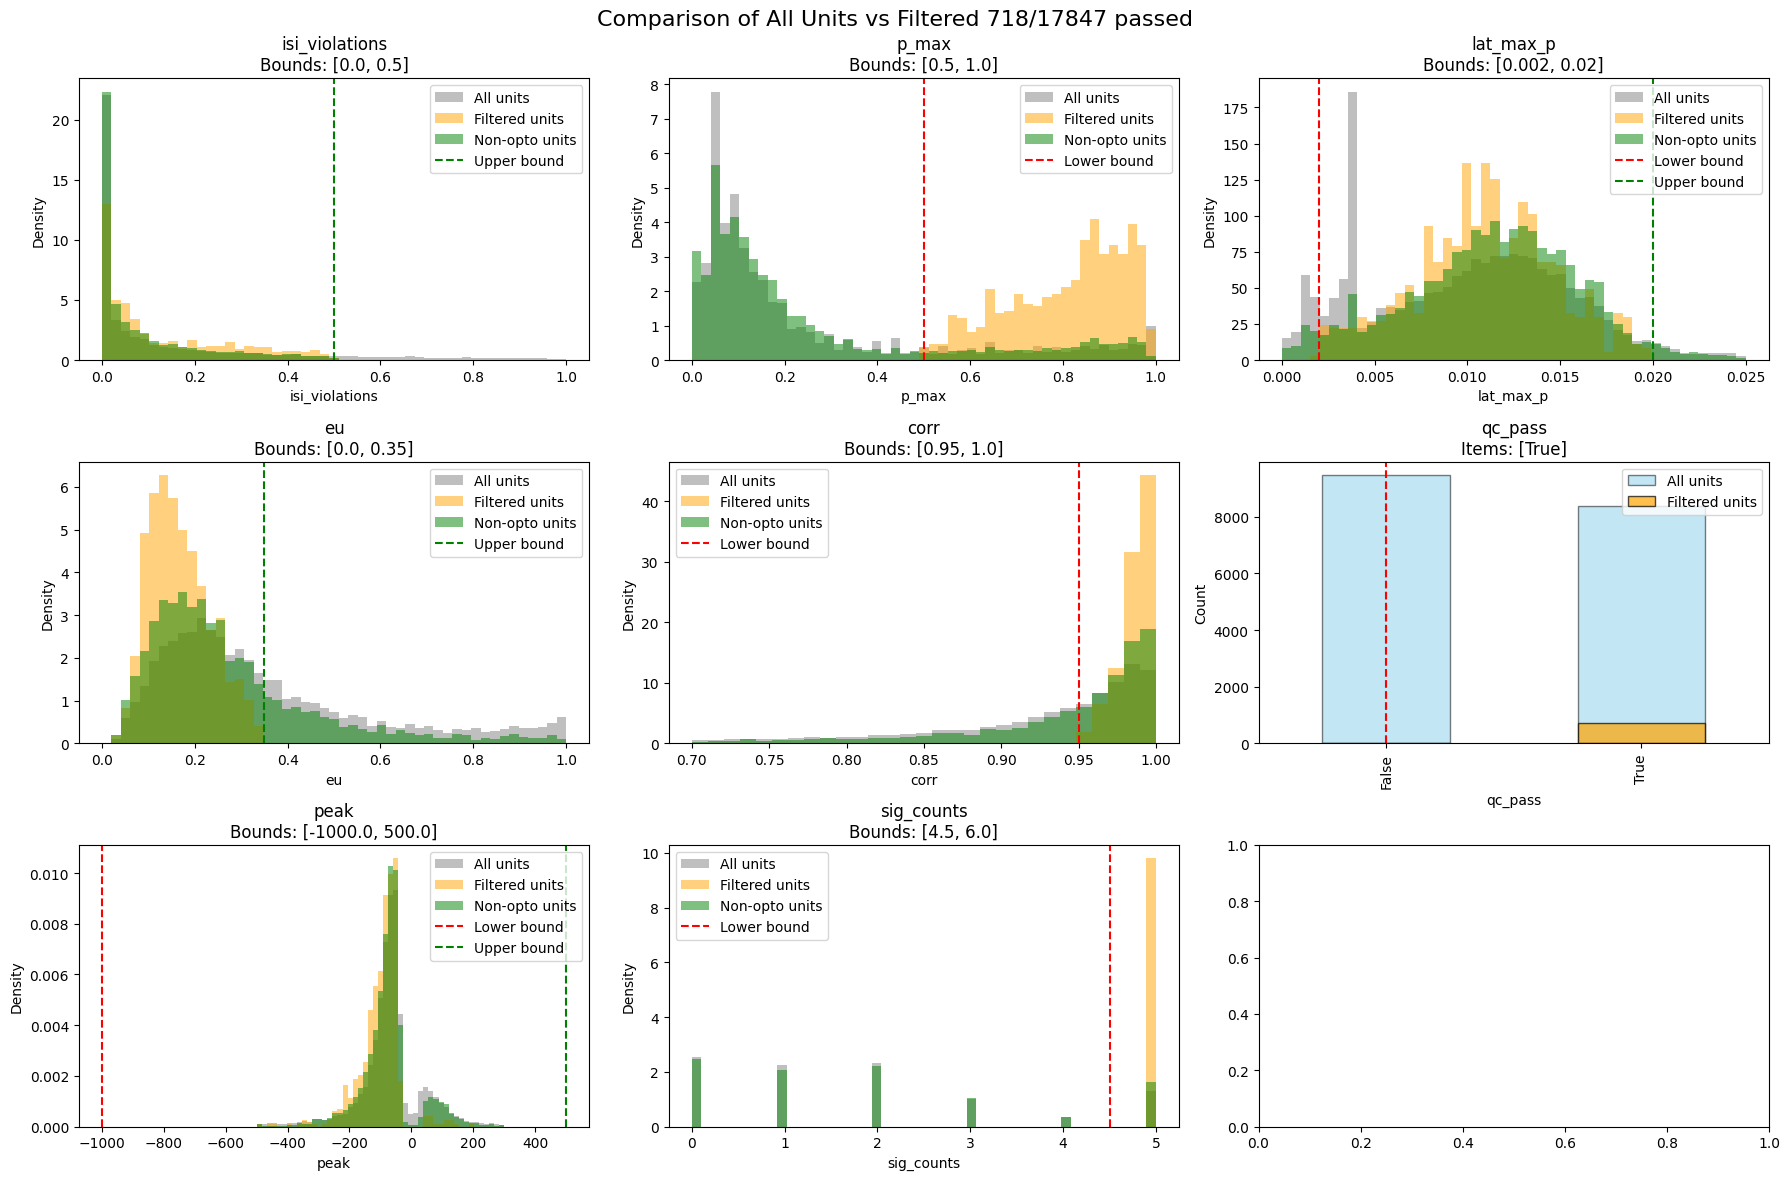

In [6]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

# Skip if loading antidromic units

In [5]:
session_list = combined_tagged_units_filtered[combined_tagged_units_filtered['probe']=='2']['session'].unique().tolist()

In [6]:
concatenate_antidromic_results_all = []
for session in session_list:
    session_dir = session_dirs(session)
    save_dir = os.path.join(session_dir['opto_dir_curated'], f'{session}_antidromic_results.pkl')
    if os.path.exists(save_dir):
        with open(save_dir, 'rb') as f:
            merged_df = pickle.load(f)
        merged_df['session'] = session
        concatenate_antidromic_results_all.append(merged_df)

In [98]:
file = '/root/capsule/scratch/751181/behavior_751181_2025-02-26_11-51-19/ephys/opto/curated/behavior_751181_2025-02-26_11-51-19_antidromic_results.pkl'
with open(file, 'rb') as f:
    merged_df = pickle.load(f)

In [103]:
merged_df[['unit_id', 't_antidromic', 't_collision']]

unit_id t_antidromic                                   t_collision  \
site           surface_LC surface_PrL surface_S1 surface_SC  surface_LC   
0          1          NaN   -1.000000        NaN        NaN         NaN   
1         24          NaN    2.384440   2.533666   0.796977         NaN   
2         35          NaN   -0.485624   6.257399  -0.768368         NaN   
3         39          NaN   27.388420  17.540788  -2.025337         NaN   
4         43          NaN    9.777990  11.626131   0.800027         NaN   
5         46          NaN    8.324316   7.305300  -0.182288         NaN   
6         49          NaN   14.690984   3.669537  -0.338467         NaN   
7         61          NaN    0.660096   4.011198  -2.117034         NaN   
8         62          NaN    2.507068   7.162486   0.664082         NaN   
9         65          NaN    7.579118   0.727128   0.912865         NaN   
10        77          NaN    1.366565   6.985084  -0.432602         NaN   
11       189          NaN   -1.109752  -2.314810  -2.625956         NaN   
12       225          NaN    9.139446  -1.293043   0.480183         NaN   
13       271          NaN   -0.121891   2.783972  -0.867248         NaN   
14       273          NaN    0.783891  25.081426   0.014218         NaN   
15       275          NaN   11.646020  35.314031  -0.636452         NaN   

                                        
site surface_PrL surface_S1 surface_SC  
0            NaN        NaN        NaN  
1       1.100530  -1.527521        NaN  
2            NaN  -1.722382        NaN  
3      -3.815281  -2.615996        NaN  
4      -1.383906  -0.768100        NaN  
5      -1.214234  -0.482290        NaN  
6      -1.094782   0.424241        NaN  
7            NaN  -1.197872        NaN  
8      -0.928026  -1.600130        NaN  
9       0.426829        NaN        NaN  
10           NaN  -1.297774        NaN  
11           NaN        NaN        NaN  
12      1.185535        NaN        NaN  
13           NaN  -0.190790        NaN  
14           NaN -11.111734        NaN  
15     -2.622114  -0.528289        NaN

In [7]:
concatenate_antidromic_results = pd.concat(concatenate_antidromic_results_all, ignore_index=True)
concatenate_antidromic_results.rename(columns={'unit_id': 'unit'}, inplace=True)

In [8]:
file = os.path.join(beh_folder, 'combined_antidromic_results.pkl')
with open(file, 'wb') as f:
    pickle.dump(concatenate_antidromic_results, f)

# Load data

In [10]:
file = os.path.join(beh_folder, 'combined_antidromic_results.pkl')
with open(file, 'rb') as f:
    concatenate_antidromic_results = pickle.load(f)

In [90]:
# select target
focus = 'PrL'
focus_save_dir = os.path.join(beh_folder, focus)
if not os.path.exists(focus_save_dir):
    os.makedirs(focus_save_dir)
cols_to_keep = [
    col for col in concatenate_antidromic_results.columns
    if col[1] in (f'surface_{focus}', '')  # keep both surface_PrL and no-site columns
]
df_focus = concatenate_antidromic_results.loc[:, cols_to_keep]
if isinstance(df_focus.columns, pd.MultiIndex):
    df_focus.columns = df_focus.columns.get_level_values(0)

combined_df = combined_tagged_units_filtered.merge(df_focus, on=['session', 'unit'], how='inner')
combined_df['t_collision'] = -combined_df['t_collision']

In [91]:
combined_df_clean = combined_df[[c for c in combined_df.columns 
               if combined_df[c].dropna().map(lambda x: isinstance(x, (str, int, float, np.number, bool))).all()]]

In [92]:
combined_df['p_auto_inhi_log'] = -np.log10(combined_df['p_auto_inhi'] + 1e-20)
combined_df['p_collision_log'] = -np.log10(combined_df['p_collision'] + 1e-20)
combined_df['p_antidromic_log'] = -np.log10(combined_df['p_antidromic'] + 1e-20)

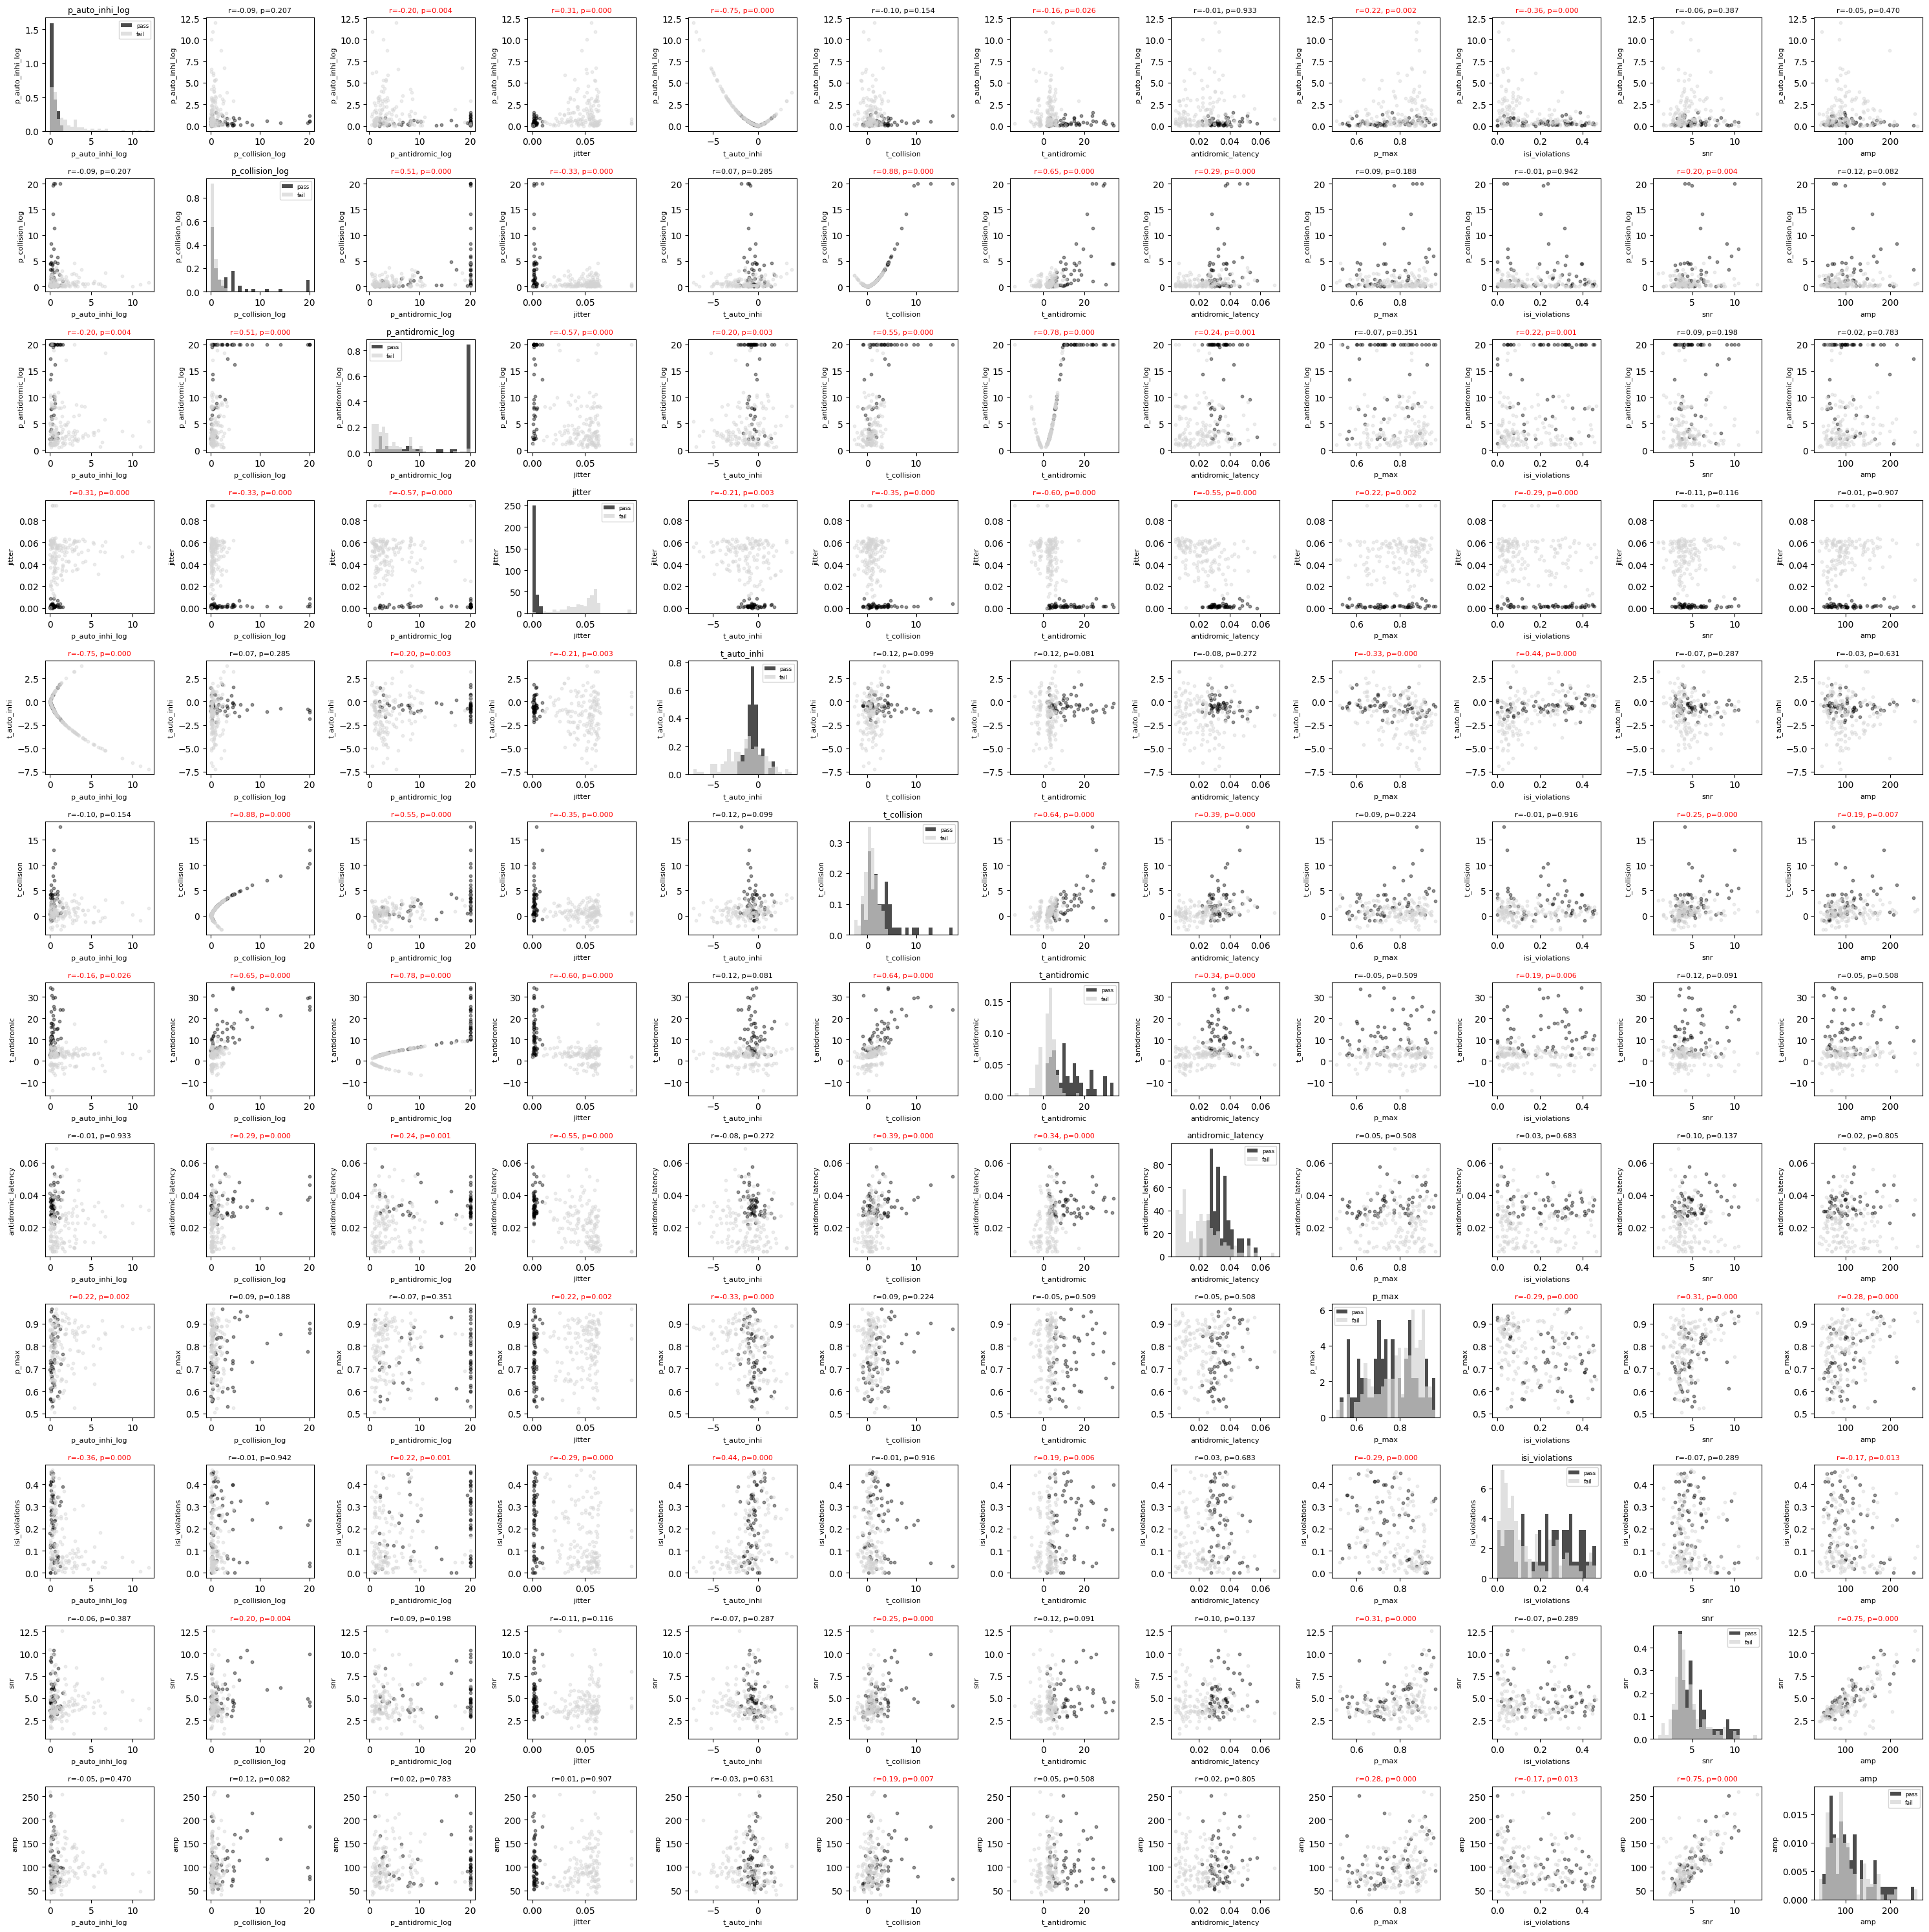

In [43]:
from scipy.stats import pearsonr

col_to_plot = [
    'p_auto_inhi_log', 'p_collision_log', 'p_antidromic_log', 'jitter',
    't_auto_inhi', 't_collision', 't_antidromic',
    'antidromic_latency', 'p_max', 'isi_violations', 'snr', 'amp'
]

# Drop rows with any NaNs in the selected columns
data = combined_df[col_to_plot].dropna()
color_code = (data['jitter']<0.010) & (data['antidromic_latency']>0.02)

n = len(col_to_plot)
fig, axes = plt.subplots(n, n, figsize=(2.5 * n, 2.5 * n))

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        x = data[col_to_plot[j]].values
        y = data[col_to_plot[i]].values
        
        if i == j:
            # diagonal: histogram
            bins = np.linspace(np.min(x), np.max(x), 30)
            ax.hist(x[color_code], bins=bins, color='k', alpha=0.7, label='pass', density=True)
            ax.hist(x[~color_code], bins=bins, color='lightgray', alpha=0.7, label='fail', density=True)
            ax.set_title(col_to_plot[i], fontsize=9)
            ax.legend(fontsize=6)
        else:
            # scatter plot
            ax.scatter(x[color_code], y[color_code], color='k', alpha=0.4, s=10)
            ax.scatter(x[~color_code], y[~color_code], color='lightgray', alpha=0.4, s=10)
            
            
            # compute Pearson correlation and p-value
            if np.isfinite(x).all() and np.isfinite(y).all() and len(x) > 1:
                r, p = pearsonr(x, y)
                color = 'red' if p < 0.05 else 'black'
                ax.set_title(f"r={r:.2f}, p={p:.3f}", color=color, fontsize=8)
            else:
                ax.set_title("r=NaN", color='black', fontsize=8)
        
        # Add x and y axis labels for every subplot
        ax.set_xlabel(col_to_plot[j], fontsize=8)
        ax.set_ylabel(col_to_plot[i], fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(focus_save_dir, 'antidromic_correlation_matrix.png'), dpi=300)
plt.show()


In [33]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)

In [95]:
combined_df['tier_1'] = (
    (combined_df['jitter'] < 0.01)
    & (combined_df['p_antidromic'] < 0.01)
    & (combined_df['t_antidromic'] > 0)
    & (combined_df['p_collision'] < 0.01)
    & (combined_df['t_collision'] > 0)
).astype(float)
combined_df['tier_2'] = (
    (combined_df['jitter'] < 0.01)
    & (combined_df['p_antidromic'] < 0.01)
    & (combined_df['t_antidromic'] > 0)
).astype(float)
combined_df['tier_1_long'] = (
    (combined_df['p_antidromic'] < 0.01)
    & (combined_df['t_antidromic'] > 0)
    & (combined_df['p_collision'] < 0.01)
    & (combined_df['t_collision'] > 0)
).astype(float)
combined_df['tier_2_long'] = (
    (combined_df['p_antidromic'] < 0.01)
    & (combined_df['t_antidromic'] > 0)
).astype(float)

combined_df['short'] = (
    (combined_df['jitter'] < 0.01)
    & combined_df['antidromic_latency']>=0.025).astype(float)


Text(0, 0.5, 'regression_log(p_collision)')

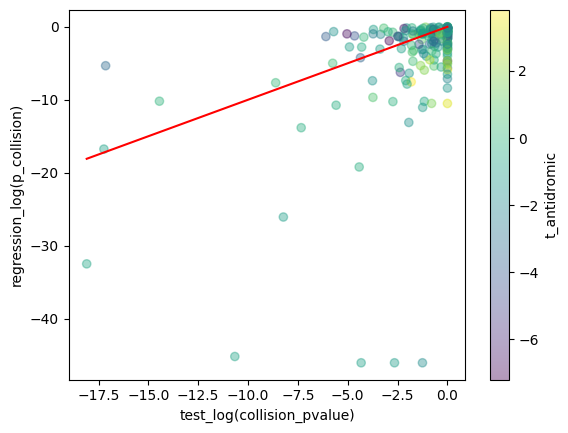

In [45]:
plt.scatter(np.log(combined_df['collision_pvalue'] + 1e-20), np.log(combined_df['p_collision'] + 1e-20), c = combined_df['t_auto_inhi'], alpha=0.4)
plt.plot([np.min(np.log(combined_df['collision_pvalue'] + 1e-20)), np.max(np.log(combined_df['collision_pvalue'] + 1e-20))],
            [np.min(np.log(combined_df['collision_pvalue'] + 1e-20)), np.max(np.log(combined_df['collision_pvalue'] + 1e-20))], color='red')
plt.colorbar(label='t_antidromic')
plt.xlabel('test_log(collision_pvalue)')
plt.ylabel('regression_log(p_collision)')

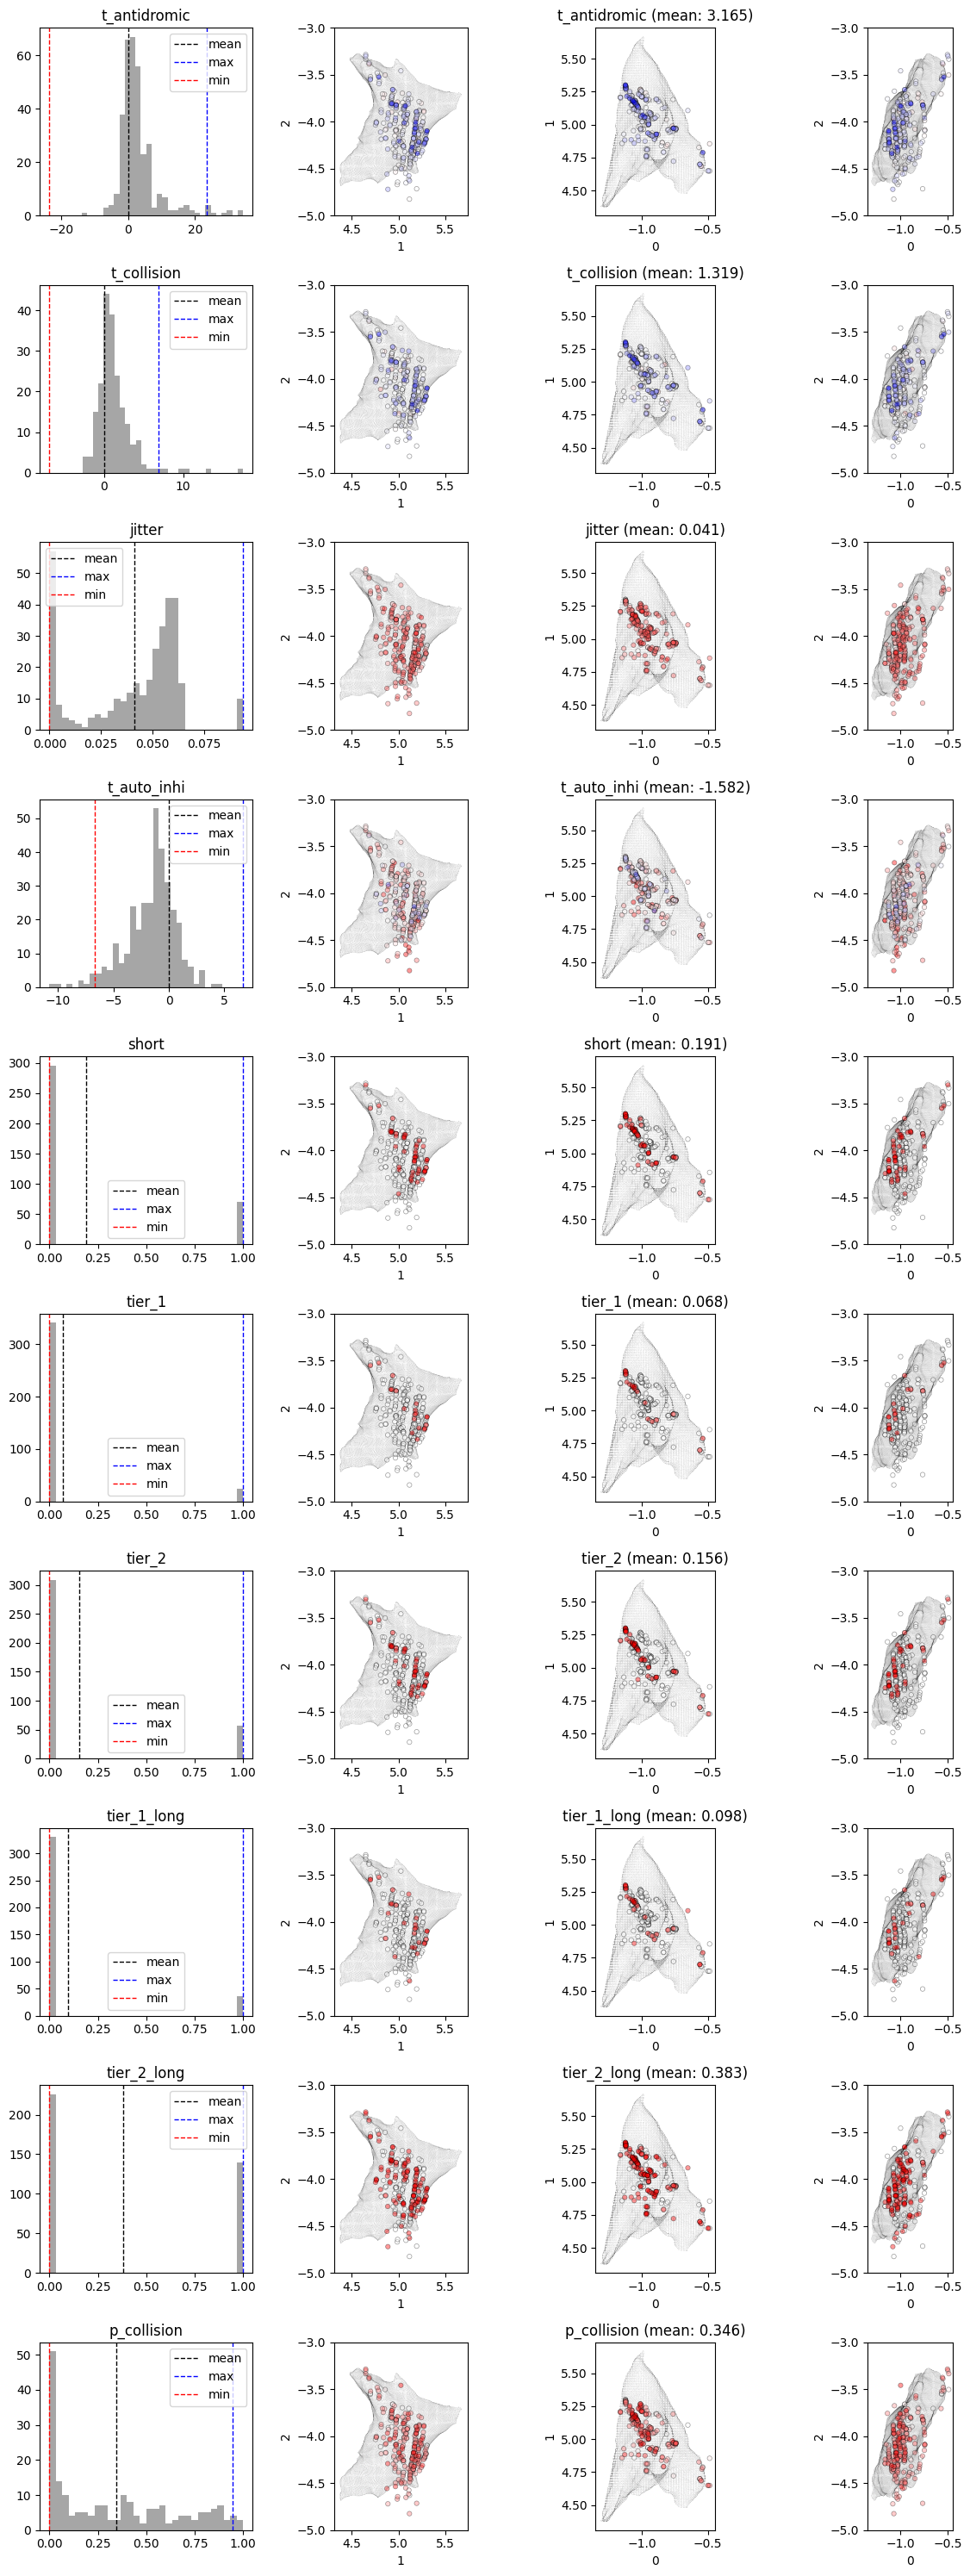

In [96]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os

features_to_plot = ['t_antidromic', 't_collision', 'jitter', 't_auto_inhi', 'short', 'tier_1', 'tier_2', 'tier_1_long', 'tier_2_long', 'p_collision']
# features_to_plot = features_beh

fig, axes = plt.subplots(len(features_to_plot), 4, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = combined_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = combined_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg))/(amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(combined_df[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # # === Compute alpha scaling from rho ===
    # alpha_scale = combined_df['rho'].values[mask]
    # alpha_scale = np.sqrt(alpha_scale)               # soften scaling
    # alpha_scale = np.clip(alpha_scale, 0.2, 0.8)     # prevent extremes

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg)
    ccfs_plot = ccfs[sort_ind]
    color_reg_plot = color_reg[sort_ind]
    # alpha_scale_plot = alpha_scale[sort_ind]

    # # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    # rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.4, s=0.05, edgecolors='none'
        )

        # scatter the points (alpha-scaled)
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors=rgba_colors,
            edgecolors='k',
            linewidths=0.5,
            alpha = 0.4,
            s=15
        )

        if plane == 'hor':
            value_mean = np.nanmean(combined_df[feature].values)
            ax.set_title(f'{feature} (mean: {value_mean:.3f})')
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(focus_save_dir, f'antidromic_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)
# plt.close()


In [47]:
import k3d
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# --- Prepare mask and derived features ---
# features_to_plot = ['t_antidromic', 't_collision', 'jitter', 't_auto_inhi', 'tier_1', 'tier_2']

# --- Anatomical coordinates ---
ccfs = combined_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml = 0
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for feature in features_to_plot:
    color = combined_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize color range to [0, 1] ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.9)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list(
            'bwr_custom', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg)) / (amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list('wr_custom', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Sort for proper rendering ===
    sort_ind = np.argsort(color_reg)
    ccfs_plot = ccfs[sort_ind]
    color_reg_plot = color_reg[sort_ind]

    # === Map to RGBA, inject alpha ===
    rgba = custom_cmap(color_reg_plot)
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    # --- Create interactive K3D plot ---
    plt_3d = k3d.plot(
        camera_auto_fit=True,
        background_color=0x000000,
        grid_visible=False
    )

    # --- Optional: anatomical mesh if available ---
    if 'mesh_vertices_mm' in locals() and 'mesh' in locals():
        faces = np.array(mesh.faces).astype(np.uint32)
        plt_3d += k3d.mesh(
            mesh_vertices_mm.astype(np.float32),
            faces,
            color=0x888888,
            opacity=0.6
        )

    # # --- Scatter points with per-point alpha ---
    # pts = k3d.points(
    #     positions=ccfs_plot.astype(np.float32),
    #     colors=colors.astype(np.uint32),
    #     point_size=0.05,
    #     shader='3d',
    #     opacity=1.0
    # )

    for ind in range(len(ccfs_plot)):
        pt = k3d.points(
            positions=ccfs_plot[ind:ind+1].astype(np.float32),
            colors=np.array([colors[ind]]).astype(np.uint32),
            point_size=0.05,
            shader='3d',
            opacity=0.6
        )
        plt_3d += pt

    # --- Add colorbar (sample colormap directly) ---
    color_map_for_bar = np.array(
        [custom_cmap(i / 255)[:3] for i in range(256)],
        dtype=np.float32
    )

    # plt_3d += k3d.color_map.ColorMap(
    #     color_map=color_map_for_bar,
    #     color_range=[np.nanmin(color), np.nanmax(color)],
    #     label=feature,
    #     position_x=0.02,
    #     position_y=0.85,
    #     width=0.015,
    #     height=0.5
    # )

    # --- Save to HTML ---
    html_path = os.path.join(focus_save_dir, '3D_links_antidromic',f'k3d_{feature}_3D.html')
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    with open(html_path, 'w') as f:
        f.write(plt_3d.get_snapshot())

    print(f"✅ Saved interactive plot: {html_path}")
    # plt_3d.display()


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_t_antidromic_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_t_collision_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_jitter_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_t_auto_inhi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_short_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_tier_1_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidromic/k3d_tier_2_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/3D_links_antidro

In [97]:
# grab all figures and save 
import shutil
target_folder = os.path.join(focus_save_dir, 'antidromic_figures')
os.makedirs(target_folder, exist_ok=True)
tiers = ['tier_1', 'tier_2']
sub_classes = ['long', 'short']
for tier in tiers:
    for sub_class in sub_classes:
        shutil.rmtree(path=os.path.join(target_folder, tier, sub_class), ignore_errors=True)
        os.makedirs(os.path.join(target_folder, tier, sub_class), exist_ok=True)

null_folder = os.path.join(target_folder, 'null_figures')
os.makedirs(null_folder, exist_ok=True)

target_folder_t1 = os.path.join(target_folder, 'tier_1', 'short')
target_folder_t2 = os.path.join(target_folder, 'tier_2', 'short')
target_folder_t1_long = os.path.join(target_folder, 'tier_1', 'long')
target_folder_t2_long = os.path.join(target_folder, 'tier_2', 'long')

for row_ind, row in combined_df.iterrows():
    session = row['session']
    unit = row['unit']
    tier_1 = row['tier_1']
    tier_2 = row['tier_2']
    tier_1_long = row['tier_1_long']
    tier_2_long = row['tier_2_long']
    
    source_folder = os.path.join(session_dirs(session)['opto_dir_curated'], 'figures', 'antidromic')
    figure_name = f'{session}_unit{unit}_opto_responses.pdf'
    source_path =  os.path.join(source_folder, figure_name)
    if not os.path.exists(source_folder):
        figure_name = f'{session}_unit{unit}.0_opto_responses.pdf'
        source_path =  os.path.join(source_folder, figure_name)
    
    if os.path.exists(source_path):
        print(f'Found figure for {session} unit {unit}.')
        if tier_1_long:
            if tier_1:
                curr_target_folder = target_folder_t1
                print(f'Copying {figure_name} to tier_1 folder...')
            else:
                curr_target_folder = target_folder_t1_long
                print(f'Copying {figure_name} to tier_1_long folder...')
        elif tier_2_long:
            if tier_2:
                curr_target_folder = target_folder_t2
                print(f'Copying {figure_name} to tier_2 folder...')
            else:
                curr_target_folder = target_folder_t2_long
                print(f'Copying {figure_name} to tier_2_long folder...')
        else:
            curr_target_folder = null_folder
            print(f'Copying {figure_name} to null folder...')
        if not np.isnan(row["jitter"]):
            jitter = int(round(1000*row["jitter"]))
        else:
            jitter = 'NA'
        
        if not np.isnan(row["antidromic_latency"]):
            antidromic_latency = int(round(1000*row["antidromic_latency"]))
        else:
            antidromic_latency = 'NA'
        shutil.copy(source_path, os.path.join(curr_target_folder, f'{session}_{unit}_col_{row["t_collision"]:.1f}_anti_{row["t_antidromic"]:.1f}_lat_{antidromic_latency}_jitter_{jitter}.pdf'
))
    else:
        print(f'Figure not found for {session} unit {unit}.')

Found figure for ecephys_713854_2024-03-05_12-01-40 unit 53.
Copying ecephys_713854_2024-03-05_12-01-40_unit53_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_12-01-40 unit 64.
Copying ecephys_713854_2024-03-05_12-01-40_unit64_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_12-01-40 unit 65.
Copying ecephys_713854_2024-03-05_12-01-40_unit65_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 0.
Copying ecephys_713854_2024-03-05_13-01-09_unit0_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 3.
Copying ecephys_713854_2024-03-05_13-01-09_unit3_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 11.
Copying ecephys_713854_2024-03-05_13-01-09_unit11_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 15.
Copying ecephys_713854_2024-03-05_13-01-09_unit15_opto_

In [67]:
# combine pdfs
target_folder = os.path.join(focus_save_dir, 'antidromic_figures')
for tier in tiers:
    for sub_class in sub_classes:
        input_folder = os.path.join(target_folder, tier, sub_class)
        output_pdf = os.path.join(target_folder, f'antidromic_{focus}_{tier}_{sub_class}.pdf')
        combine_pdf_big(input_folder, output_pdf)
        print(f'Combined PDF saved to {output_pdf}')

Processing 13 files in /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/tier_1/long
Combined PDF saved as: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/antidromic_PrL_tier_1_long.pdf
Combined PDF saved to /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/antidromic_PrL_tier_1_long.pdf
Processing 26 files in /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/tier_1/short
Combined PDF saved as: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/antidromic_PrL_tier_1_short.pdf
Combined PDF saved to /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/antidromic_PrL_tier_1_short.pdf
Processing 89 files in /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/tier_2/long
Combined PDF saved as: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL/antidromic_figures/antidromic_PrL_

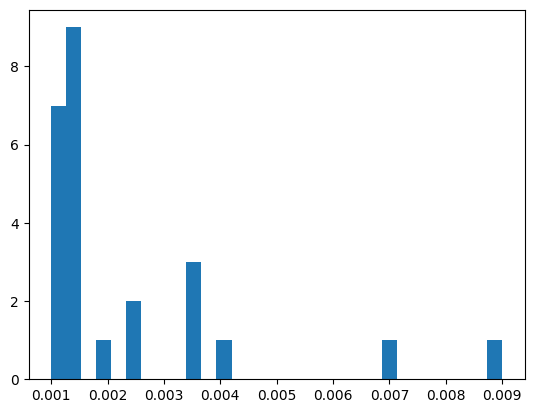

In [68]:
plt.hist(combined_df[combined_df['tier_1']>0]['jitter'], bins = 30);